# Deterministic Real-Business Cycle Model 

The economy consists of a number of identical households. The optimal growth problem in discrete time with no uncertainty can be written as follows:
$$
\begin{eqnarray}
 \max_{ \{ c(t), k(t) \}_{t=0}^{\infty} }
 \sum_{t=0}^{\infty}
 \beta^t
 u(c(t))
\end{eqnarray}
$$
subject to
$$
\begin{eqnarray}
 k(t+1) = f(k(t)) + (1-\delta)k(t) - c(t)
\end{eqnarray}
$$
with $k(t) \geq 0$ and given $k(0) > 0$.

Rewriting the optimal growth problem as a dynamic programming  problem. Let the choice (or control) variable be next date's capital stock, denoted $s$. Then the resource constraint, shown in the optimal growth problem, implies that the current consumption is given by $$c=f(k)+(1-\delta)k-s$$

The optimal growth problem can be written in the following recursive form:
$$
V(k) = \max_{ s\in G(k) } 
\{
 u( f(k) + (1-\delta)k - s ) + \beta V(s)
\}
$$
where $G(k)$ is the constraint correspondence, given by the interval $[0, f(k)+(1-\delta)k]$. This constraint requires that consumption and the capital stock be nonnegative.

The functional form used in the implementation below is:
$$
\begin{eqnarray}
 u(c(t)) = \log(c(t))    
\end{eqnarray}
$$
and 
$$
\begin{eqnarray}
 f(k) = k^{\alpha}
\end{eqnarray}
$$


The first-order conditions for this problem are given by:
$$
\begin{eqnarray}
 u'(c(t)) = \beta u'(c(t+1)) [ f'(k(t)) + 1 - \delta ] \\
 f(k(t)) + (1-\delta)k(t) - k(t+1) - c(t) = 0
\end{eqnarray}
$$

In [415]:
# Load packages
using Optim
using Plots
using Statistics
using NLsolve

In [416]:
# Functions
function fun_max(mX)
    # Find maximum of a matrix along the columns
    # Input: mX of dimension m x n
    # Output vMax of dimension n
    iCols = size(mX, 2);
    vMax = zeros(iCols,1);
    for i = 1:iCols
            temp_max = findmax( mX[:,i] );
            vMax[i] = temp_max[1];
    end
    return vMax;
end

function fun_max_index(mX)
    # Find maximum of a matrix along the columns
    # and give the index
    # Input: mX of dimension m x n
    # Output vMax of dimension n
    iCols = size(mX, 2);
    vMax_index = zeros(iCols,1);
    for i = 1:iCols
            temp_max = findmax( mX[:,i] );
            vMax_index[i] = temp_max[2];
    end
    return vMax_index;
end

fun_max_index (generic function with 1 method)

In [417]:
# Structural parameters
pAlpha = 0.7;
pBeta = 0.92;
pDelta = 0.7;

In [418]:
# Computing the steady state (analytical solution)
dKss_an = ( (1-pBeta*(1-pDelta))/pBeta )^(1/pAlpha);
dCss_an = dKss_an^pAlpha+(1-pDelta)*dKss_an-dKss_an;
display(dKss_an)
display(dCss_an)

0.7101632564949257

0.2898422421926824

In [419]:
# Computing the steady state (numerical solution)
PARAMS = [ pAlpha, pDelta, pBeta ];
function f!(F,x,PARAMS)

    # 1  2  
    # c, k

    pAlpha = PARAMS[1];
    pDelta = PARAMS[2];
    pBeta  = PARAMS[3];
    
    c = x[1];
    k = x[2];
    
    uc = 1/c
    fk = k^pAlpha
    
    F[1] = pBeta*uc*( fk + 1 - pDelta ) - uc
    F[2] = fk + (1-pDelta)*k - k - c
    
end


SteadyState = nlsolve((F,x) ->f!(F,x,PARAMS), [ dCss_an, dKss_an ], iterations = 1000 , method = :newton)

# Defining the steady state
dCss = SteadyState.zero[1];
dKss = SteadyState.zero[2];

display(dKss)
display(dCss)


0.7101632564949257

0.2898422421926824

In [420]:
# Algorithm related parameters
iIter = 5000;
iGridPointsK = 1000;
iToler = 10e-8;

# Constructing the grid
dKmin = dKss * 0.22;
dKmax = dKss * 2.0;


iStepK = (dKmax-dKmin) / (iGridPointsK-1);
vK = collect(dKmin:iStepK:dKmax);
iGridPointsK = size(vK,1);

#display(vK)

In [421]:
mK_S = zeros(iGridPointsK, iGridPointsK);

# Storage space
for idxKP = 1:iGridPointsK
    for idxK = 1:iGridPointsK
        mK_S[idxKP,idxK] = vK[idxK];
    end
end

mK = mK_S;
mKP = mK';


mC = mK.^pAlpha + (1-pDelta).*mK - mKP;

#display( mC )

In [422]:
# Eliminate negative consumption
mCP = mC .> 0;
mPC = ones(iGridPointsK, iGridPointsK) - mCP;
z = 10e-5;
mC = mC.*mCP + z*mPC;

# Initialize value function
mU = log.( mC ) ;

mCF = mC;

mVNew = log.(mCF);
global vVOld = fun_max( mU+pBeta*mVNew ); # ( [iGridPointsK*iGridPointsN] x 1 )


vEps = zeros(iIter,1);

In [423]:
global counter = 0;
### Main Iteration - BEGIN ###
for idxIter=1:iIter

 global vVOld;
 global  counter;

 vVNew = fun_max(mU+pBeta*(ones(iGridPointsK,1)*vVOld')');

 iDiff = ( abs.(vVOld-vVNew) ) ./ vVOld;

 dEps = sum(sqrt.((iDiff).^2));
 vEps[idxIter,1] = dEps;

 if sum(sqrt.((iDiff).^2)) <= iToler
  vVOld = vVNew;
  break
 else
  vVOld = vVNew;
 end
 
 counter = counter + 1;

end
### Main Iteration - END ###

print("\n");
print("\n");
print("Iterations needed to reach convergence : ")
print(counter);
print("\n");



Iterations needed to reach convergence : 246


In [424]:
plot(vEps[100:iIter],legend=false,title="Convergence of the value iteration")
xlabel!("iterations")
ylabel!("epsilon")

# Preparing maximum values and indices for policy function
maxR = fun_max(mU+pBeta*(ones(iGridPointsK,1)*vVOld')');
idxR = fun_max_index(mU+pBeta*(ones(iGridPointsK,1)*vVOld')');

print("Maximum value");
print("\n");
print(maxR);
print("\n");
print("\n");
print("Index")
print("\n");
print(idxR);
print("\n");
print("\n");
print("Capital grid");
print("\n");
print(vK);
print("\n");
print("\n");


Maximum value


[-19.246489777718686; -19.226945870589873; -19.207549679313097; -19.188300761744784; -19.16919980076462; -19.150244929622914; -19.131433181378547; -19.112761674903165; -19.094228094786615; -19.075836764334955; -19.057575574865652; -19.03944317727518; -19.021439620142218; -19.00356105012894; -18.985809026197828; -18.96818615238525; -18.95068537246851; -18.93330650667918; -18.916051202336483; -18.898914395520816; -18.881889820350565; -18.864976899039238; -18.84817076806247; -18.831475684484246; -18.81489319359758; -18.798420363848354; -18.78205715790213; -18.765800168345297; -18.74964281422834; -18.73358542667479; -18.717630045807955; -18.70177990831207; -18.686023610240053; -18.670363012443744; -18.654801234149847; -18.639335347211773; -18.623966059972805; -18.608686962027967; -18.59349730427922; -18.57839736685722; -18.563387641440745; -18.548469644267453; -18.533642158569215; -18.518896729713866; -18.5042405796817; -18.489667109773368; -18.47517376238801; -18.46076163687906; -18.44643

; -13.692874330276435; -13.690491839453026; -13.688110477147125; -13.685732253378832; -13.683357975704498; -13.680985103616994; -13.678612987234509; -13.676242647388632; -13.673875230740023; -13.67150918339959; -13.669145865991196; -13.666784693170873]

Index
[52.0; 54.0; 55.0; 56.0; 57.0; 58.0; 59.0; 60.0; 61.0; 62.0; 63.0; 64.0; 65.0; 66.0; 67.0; 68.0; 69.0; 70.0; 71.0; 72.0; 73.0; 74.0; 76.0; 77.0; 78.0; 79.0; 80.0; 81.0; 82.0; 83.0; 84.0; 85.0; 86.0; 87.0; 88.0; 89.0; 90.0; 91.0; 92.0; 93.0; 94.0; 95.0; 96.0; 97.0; 98.0; 99.0; 100.0; 101.0; 102.0; 103.0; 104.0; 105.0; 106.0; 107.0; 108.0; 109.0; 110.0; 111.0; 112.0; 112.0; 113.0; 114.0; 115.0; 116.0; 117.0; 118.0; 119.0; 120.0; 121.0; 122.0; 123.0; 124.0; 125.0; 126.0; 127.0; 128.0; 129.0; 130.0; 131.0; 132.0; 133.0; 134.0; 135.0; 136.0; 137.0; 137.0; 138.0; 139.0; 140.0; 141.0; 142.0; 143.0; 144.0; 145.0; 146.0; 147.0; 148.0; 149.0; 150.0; 151.0; 152.0; 153.0; 153.0; 154.0; 155.0; 156.0; 157.0; 158.0; 159.0; 160.0; 161.0; 162.0; 1

[0.15623591642888365, 0.15750127238139713, 0.15876662833391061, 0.1600319842864241, 0.16129734023893758, 0.16256269619145106, 0.16382805214396454, 0.16509340809647802, 0.1663587640489915, 0.16762412000150498, 0.16888947595401846, 0.17015483190653194, 0.17142018785904542, 0.1726855438115589, 0.1739508997640724, 0.1752162557165859, 0.17648161166909937, 0.17774696762161285, 0.17901232357412633, 0.1802776795266398, 0.1815430354791533, 0.18280839143166677, 0.18407374738418025, 0.18533910333669373, 0.18660445928920721, 0.1878698152417207, 0.18913517119423418, 0.19040052714674766, 0.19166588309926114, 0.19293123905177462, 0.1941965950042881, 0.19546195095680158, 0.19672730690931506, 0.19799266286182854, 0.19925801881434202, 0.2005233747668555, 0.20178873071936898, 0.20305408667188246, 0.20431944262439594, 0.20558479857690942, 0.2068501545294229, 0.20811551048193638, 0.20938086643444986, 0.21064622238696334, 0.21191157833947682, 0.2131769342919903, 0.21444229024450379, 0.21570764619701727, 0.2

0.985044065325214, 0.9863094212777275, 0.987574777230241, 0.9888401331827544, 0.990105489135268, 0.9913708450877814, 0.9926362010402949, 0.9939015569928084, 0.9951669129453219, 0.9964322688978353, 0.9976976248503489, 0.9989629808028623, 1.0002283367553757, 1.0014936927078892, 1.0027590486604028, 1.004024404612916, 1.0052897605654296, 1.0065551165179432, 1.0078204724704567, 1.00908582842297, 1.0103511843754835, 1.011616540327997, 1.0128818962805106, 1.014147252233024, 1.0154126081855375, 1.016677964138051, 1.0179433200905645, 1.0192086760430779, 1.0204740319955914, 1.021739387948105, 1.0230047439006185, 1.0242700998531318, 1.0255354558056453, 1.0268008117581588, 1.0280661677106724, 1.0293315236631857, 1.0305968796156992, 1.0318622355682128, 1.0331275915207263, 1.0343929474732396, 1.0356583034257532, 1.0369236593782667, 1.0381890153307802, 1.0394543712832935, 1.040719727235807, 1.0419850831883206, 1.0432504391408342, 1.0445157950933475, 1.045781151045861, 1.0470465069983745, 1.0483118629

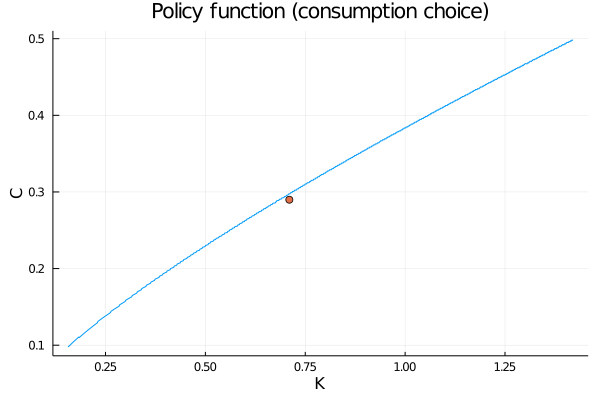

In [425]:
print("\n");
print("\n");

# Extending the grid where we evaluate variables
vK_L = vK ;

policyC = ones(iGridPointsK,1);

for idx = 1:iGridPointsK
    policyC[idx] = mC[ floor(Int, idxR[idx]) , idx ]
end

plot(vK_L, policyC, title="Policy function (consumption choice)", legend=false)
scatter!([dKss],[dCss])
xlabel!("K")
ylabel!("C")


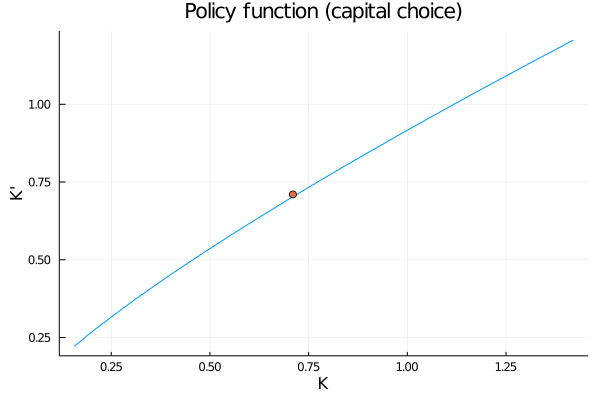

In [426]:
policyK = ones(iGridPointsK,1);

for idx = 1:iGridPointsK
    policyK[idx] = mKP[ floor(Int, idxR[idx]) , idx ]
end

plot(vK_L, policyK, title="Policy function (capital choice)", legend=false)
scatter!([dKss],[dKss])
xlabel!("K")
ylabel!("K'")

Note: Steady state is not always on policy function, when changing the parameters. Find out why?